# Image Segmentation on BraTS 2D lesion-centered MRI scans

This notebook shows how to perform brain tumor segmentations from T1 MRI scans.
The dataset comprises T1, T2, T1ce and FLAIR images.

There are 1251 subjects, every subject has 4 modalities, for every modality there are 3 2D sections crossing the lesion baricentre.
For every subject and section, there is also a lesion mask serving as ground truth.

The objective of this notebook can be expanded towards using multiple views and/or multiple modalities together, and/or testing which modalities are better for segmenting tumor lesions.

This notebook employs the torch and MONAI frameworks, and the UNet architecture.

## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import math
import pickle
import time
import matplotlib.pyplot as plt
import nilearn as nil
from nilearn.datasets import load_mni152_template
from nilearn import plotting
import nibabel as nib
import torch
from torch import nn
import torchvision
import monai
from monai.data import DataLoader, Dataset, CacheDataset, SmartCacheDataset
from monai.config import print_config
from monai.transforms import (
    LoadImaged,
    Compose,
    CropForegroundd,
    CopyItemsd,
    SpatialPadd,
    EnsureChannelFirstd,
    Spacingd,
    OneOf,
    SomeOf,
    ScaleIntensityRanged,
    RandSpatialCropSamplesd,
    RandCoarseDropoutd,
    RandCoarseShuffled,
    RandSpatialCropd,
    RandAdjustContrastd,
    ResizeWithPadOrCropd,
    Resized,
    RandRotated,
    NormalizeIntensityd,
    ScaleIntensityRangePercentilesd,
    ScaleIntensityRangePercentiles,
    RandGaussianSmoothd,
    RandGaussianNoised,
    RandFlipd,
    RandCoarseDropoutd,
    RandKSpaceSpikeNoised,
    RandHistogramShiftd,
    RandGaussianSharpend,
    NormalizeIntensityd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    ResizeWithPadOrCropd,
    GaussianSmoothd,
    ConvertToMultiChannelBasedOnBratsClassesd,
    ConcatItemsd,
)

## Data Paths 

In [4]:
REPO_PATH = os.getcwd()
BRATS_PATH = REPO_PATH + "/BRATS_2D/"

In [5]:
total_file_list = os.listdir(BRATS_PATH)
len(total_file_list)

18765

The filenames in the directory follow a specific convention.\
For inputs, the filename is:\
"SUBJECT{XXXX}_MODALITY{XX}_PLANE{XX}.npy"
\
For labels, the filename is:\
"SUBJECT{XXXX}_MASK_PLANE{XX}.npy"\
The label is valid for all modalities of the same subject and plane!

## Data Inspection

Let's load images from the first subject, subject 0.
We will load each view of each modality separately, and then combined in RGB-A format.

In [6]:
subject_ID = 0
modalities = ["t1", "t2", "t1ce", "flair"]
planes = ["00", "01", "10"]

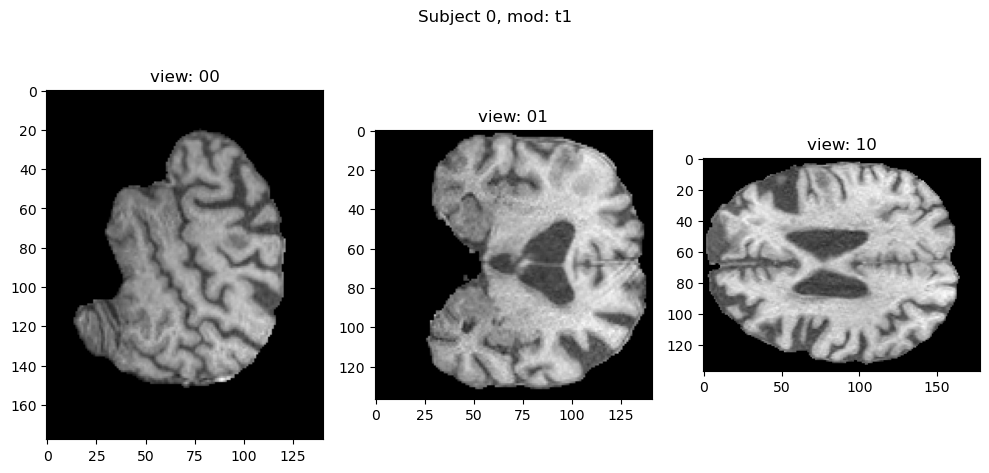

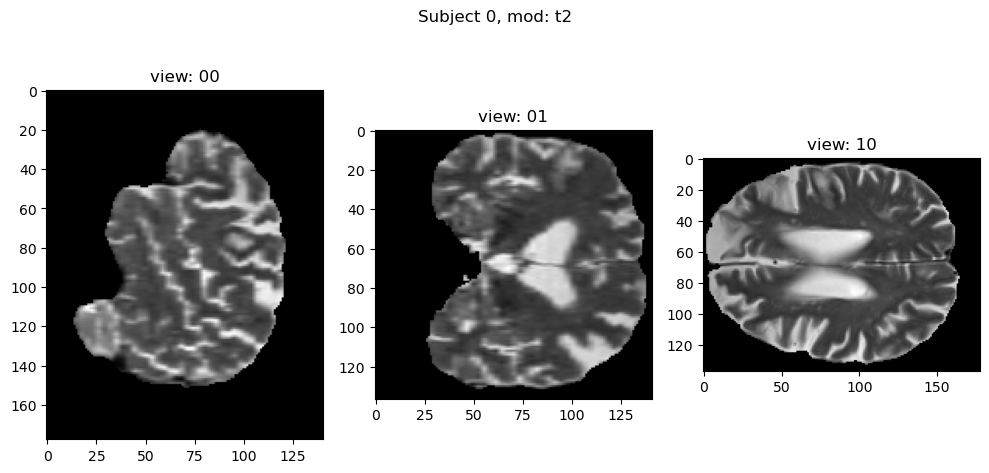

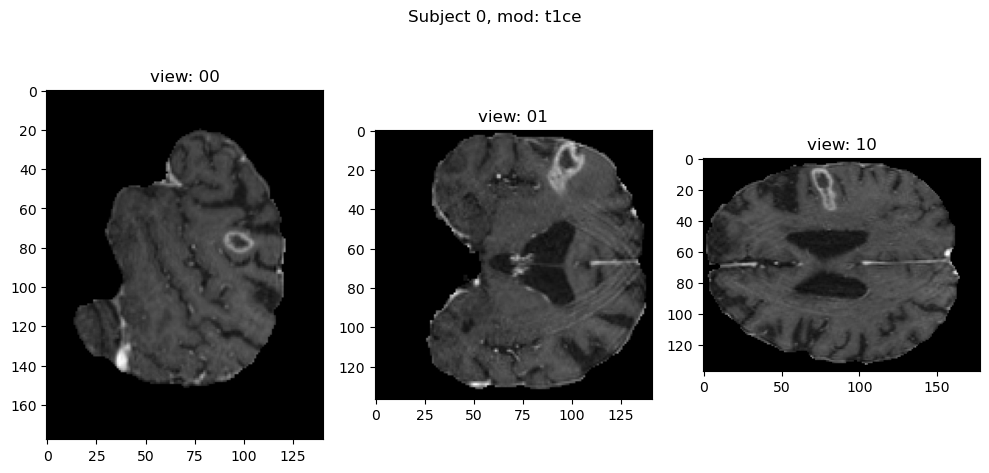

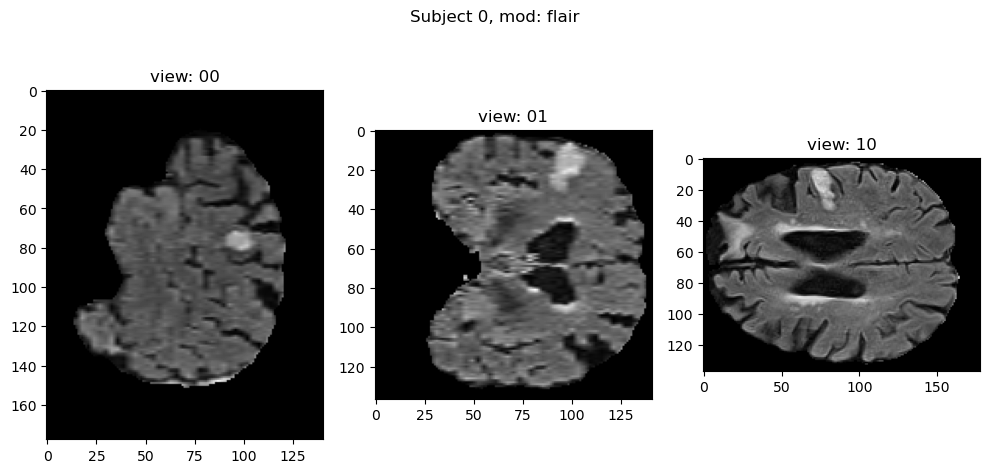

In [7]:
# Only loading the images separately
# iterate over modalities
for modality in modalities:
    plt.figure(figsize=(10,5))
    # iterate over planes
    for i, plane in enumerate(planes):
        filename = f"SUBJECT{subject_ID}_MODALITY{modality}_PLANE{plane}.npy" # format string with {variables}

        # open the file with the correct name in the correct folder
        with open(BRATS_PATH+filename, 'rb') as file:
            image = np.load(file)
        plt.subplot(1,3,i+1)
        plt.imshow(image, cmap="gray")
        plt.title(f"view: {plane}")
        
    plt.suptitle(f"Subject {subject_ID}, mod: {modality}")
    plt.tight_layout()
    plt.show()
    plt.close()

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

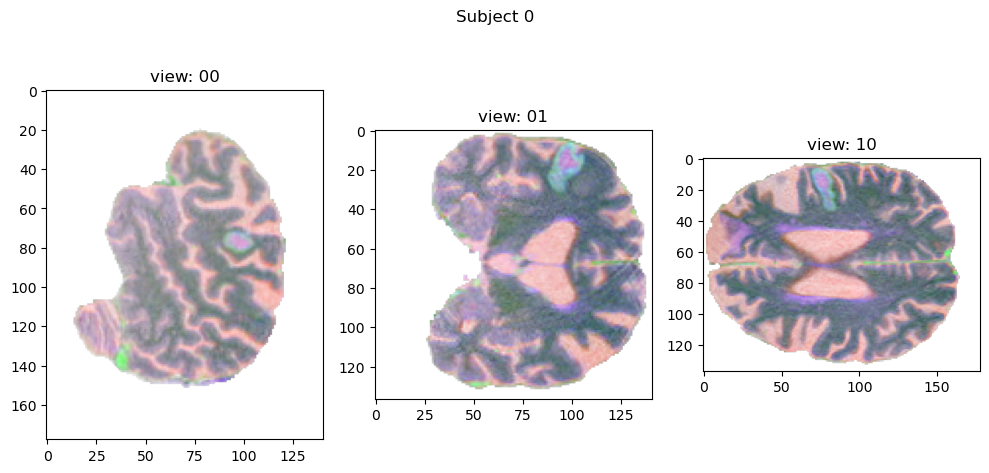

In [8]:
# Loading images and combining them

# create a dictionary containing the modalities
image_dict = {}
for modality in modalities:
    plt.figure(figsize=(10,5))
    # iterate over planes
    # create a dictionary containing the planes
    image_dict[modality] = {}
    for i, plane in enumerate(planes):
        filename = f"SUBJECT{subject_ID}_MODALITY{modality}_PLANE{plane}.npy" # format string with {variables}

        # open the file with the correct name in the correct folder
        with open(BRATS_PATH+filename, 'rb') as file:
            image_dict[modality][plane] = np.load(file)
# now we have all planes for all modalities

plt.figure(figsize=(10,5))
for i, plane in enumerate(planes):
    plt.subplot(1,3,i+1)
    image = np.stack([image_dict["t2"][plane], image_dict["t1ce"][plane], image_dict["flair"][plane], image_dict["t1"][plane]])
    
    # the image has 4 channels (RGB-A), 1 for each modality, but plt.imshow() wants the channel dimension for last
    image = image.transpose(1,2,0)
    
    # min-max scaling in the channels, you can try standard scaling
    image = (image - np.min(image, axis=(0,1), keepdims=True)) / (np.max(image, axis=(0,1), keepdims=True) - np.min(image, axis=(0,1), keepdims=True))
    
    plt.imshow(image, cmap="gray")
    plt.title(f"view: {plane}")
        
plt.suptitle(f"Subject {subject_ID}")
plt.tight_layout()
plt.show()
plt.close()

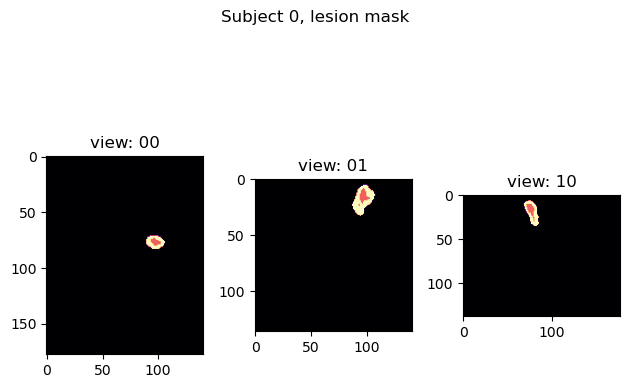

In [9]:
for i, plane in enumerate(planes):
    filename = f"SUBJECT{subject_ID}_MASK_PLANE{plane}.npy" # format string with {variables}

    # open the file with the correct name in the correct folder
    with open(BRATS_PATH+filename, 'rb') as file:
        image = np.load(file)
    plt.subplot(1,3,i+1)

    # the tissue class is 0 or 1, for every channel, channel is the first dimension,
    # we first put the channel dimension last, and then we sum the lesion classes to obtain the tumor region class
    image = image.transpose(1,2,0).sum(axis=-1)
    plt.imshow(image, cmap="magma")
    plt.title(f"view: {plane}")
    
plt.suptitle(f"Subject {subject_ID}, lesion mask")
plt.tight_layout()
plt.show()
plt.close()

## Training set definition

In [10]:
TRAIN_PATH = BRATS_PATH

######################
# DATASET DEFINITION #
######################

subjects_ID_list = list(range(1251))

# Notice here it only takes plane 00 of every subject
brains_t1_t = [TRAIN_PATH+f"SUBJECT{subject}_MODALITYt1_PLANE{'00'}.npy" for subject in subjects_ID_list]
brains_t2_t = [TRAIN_PATH+f"SUBJECT{subject}_MODALITYt2_PLANE{'00'}.npy" for subject in subjects_ID_list]
brains_t1ce_t = [TRAIN_PATH+f"SUBJECT{subject}_MODALITYt1ce_PLANE{'00'}.npy" for subject in subjects_ID_list]
brains_flair_t = [TRAIN_PATH+f"SUBJECT{subject}_MODALITYflair_PLANE{'00'}.npy" for subject in subjects_ID_list]

masks_t = [TRAIN_PATH+f"SUBJECT{subject}_MASK_PLANE{'00'}.npy" for subject in subjects_ID_list]

# Taking only T1 images for now...
train_data = [{"image_t1": brain_t1, "mask": mask} for brain_t1, mask in zip(brains_t1_t, masks_t)]

In [11]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image_t1", "mask"], image_only=True),
        EnsureChannelFirstd(keys=["image_t1"]),
        CropForegroundd(keys=["image_t1","mask"], source_key="image_t1"),
        ConcatItemsd(keys=["image_t1"], name="image"),
        Spacingd(keys=["image", "mask"], pixdim=(1,1,1), mode=("trilinear", "trilinear")),
        SpatialPadd(keys=["image", "mask"], spatial_size=(256,256), method="symmetric", mode="constant")
        # you can add data augmentations here, see Imports of monai.transforms
]
)

/Users/pietro/miniconda3/envs/progettoDeep/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [12]:
check_ds = Dataset(data=train_data, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1, num_workers=1)
from monai.utils import first
check_data = next(iter(check_loader))
image = check_data["image"]
label = check_data["mask"]
print(f"image shape: {image.shape}")
print(f"mask shape: {label.shape}")

image shape: torch.Size([1, 1, 256, 256])
mask shape: torch.Size([1, 3, 256, 256])


Data are loaded with shape (B, C, H, W), B: batch size; C: channels; H: height; W: width

## Data Class and Data Loader

In [13]:
# Define DataLoader using MONAI, CacheDataset needs to be used
# from monai.data.utils import pad_list_data_collate
BATCH_SIZE = 32
if BATCH_SIZE > 1:
        def collate_fn(batch):
            return monai.data.utils.pad_list_data_collate(batch, method="symmetric", mode="replicate")

In [14]:
train_ds = Dataset(data=train_data, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=collate_fn)

## Model definition

In [15]:
model = monai.networks.nets.UNet(spatial_dims=2, in_channels=1, out_channels=3, channels=[16,32,64], 
                                 strides=[2,2], kernel_size=3, up_kernel_size=3,
                                 act='PRELU', norm='INSTANCE', 
                                 dropout=0.1, bias=True)

In [16]:
def count_pms(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [17]:
count_pms(model)

38007

## Define Training recipe

In [35]:
from monai.losses import DiceLoss, DiceCELoss, DiceFocalLoss, GeneralizedDiceLoss, GeneralizedDiceFocalLoss, GeneralizedWassersteinDiceLoss
from monai.metrics import DiceMetric, DiceHelper

LR = 1e-3

max_epochs = 20
loss_function = DiceCELoss(lambda_ce=0.5, sigmoid=True)
dice_metric = DiceMetric(include_background=True, reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), LR)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

## Model Training

In [36]:
model.to(device)       
print(next(model.parameters()).device)

mps:0


----------
epoch 1/20
epoch 1 average loss: 0.6432
current epoch: 1 train_set mean dice: 0.4182
time consuming of epoch 1 is: 42.7577
inspection of results with random sample from training


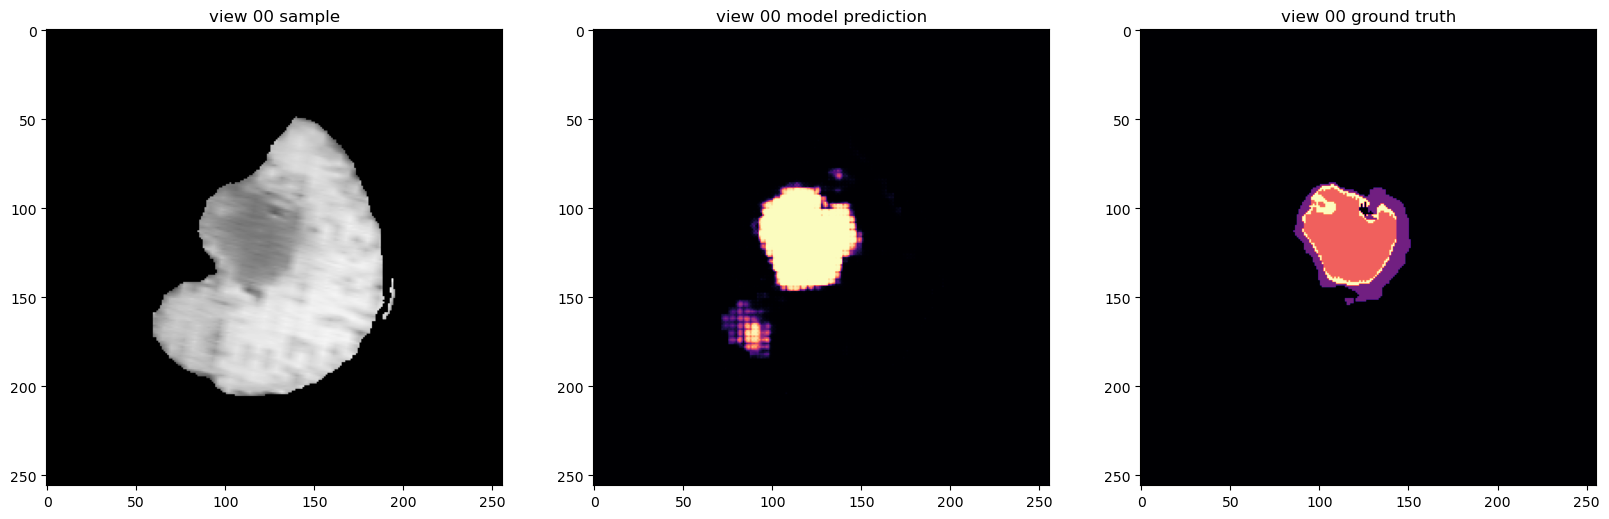

----------
epoch 2/20
epoch 2 average loss: 0.6361
current epoch: 2 train_set mean dice: 0.4195
time consuming of epoch 2 is: 28.7449
inspection of results with random sample from training


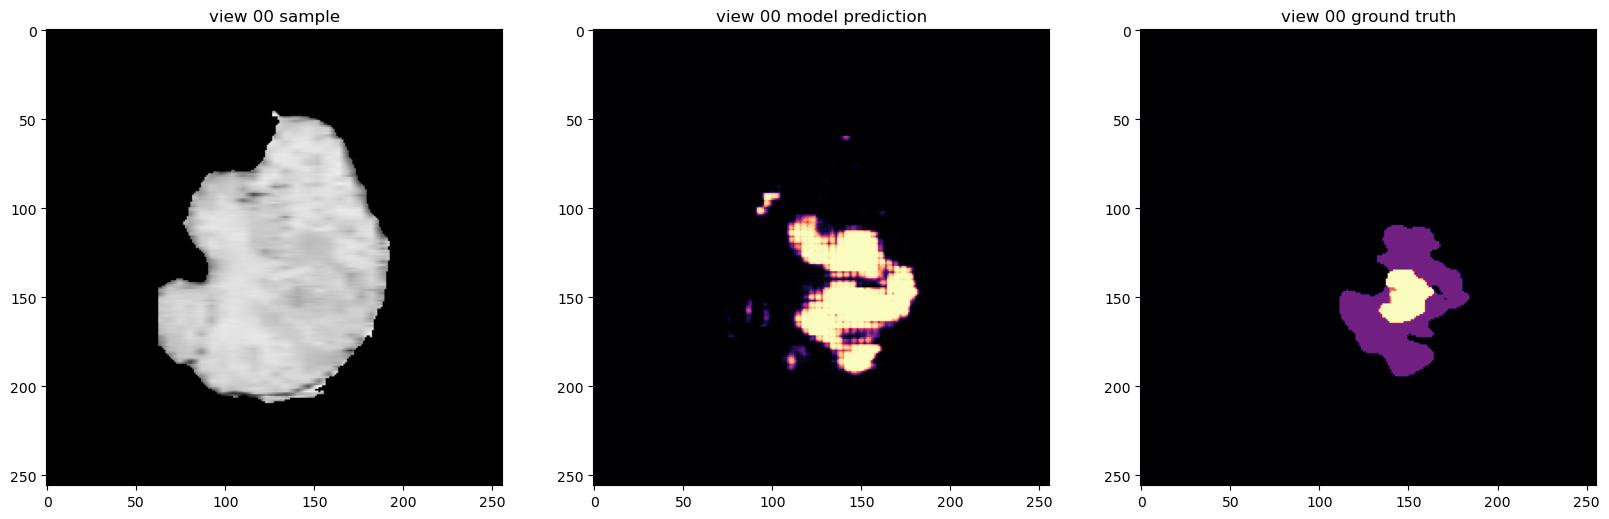

----------
epoch 3/20
epoch 3 average loss: 0.6298
current epoch: 3 train_set mean dice: 0.4255
time consuming of epoch 3 is: 25.8986
inspection of results with random sample from training


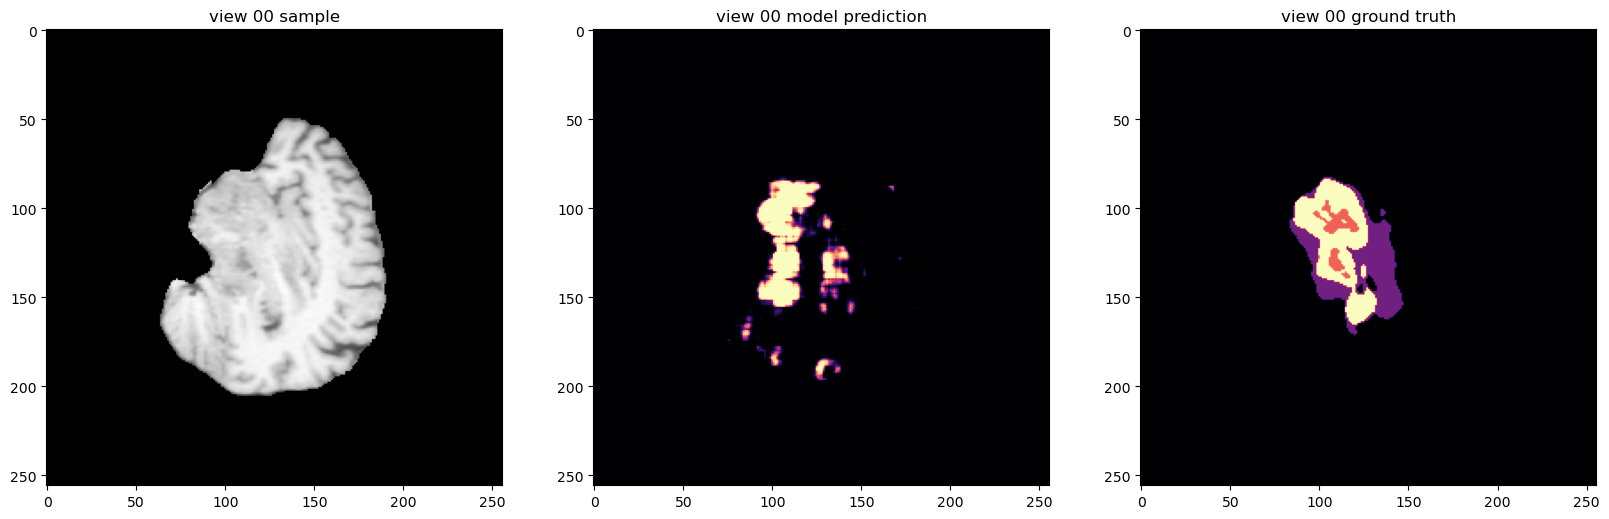

----------
epoch 4/20
epoch 4 average loss: 0.6321
current epoch: 4 train_set mean dice: 0.4246
time consuming of epoch 4 is: 25.9025
inspection of results with random sample from training


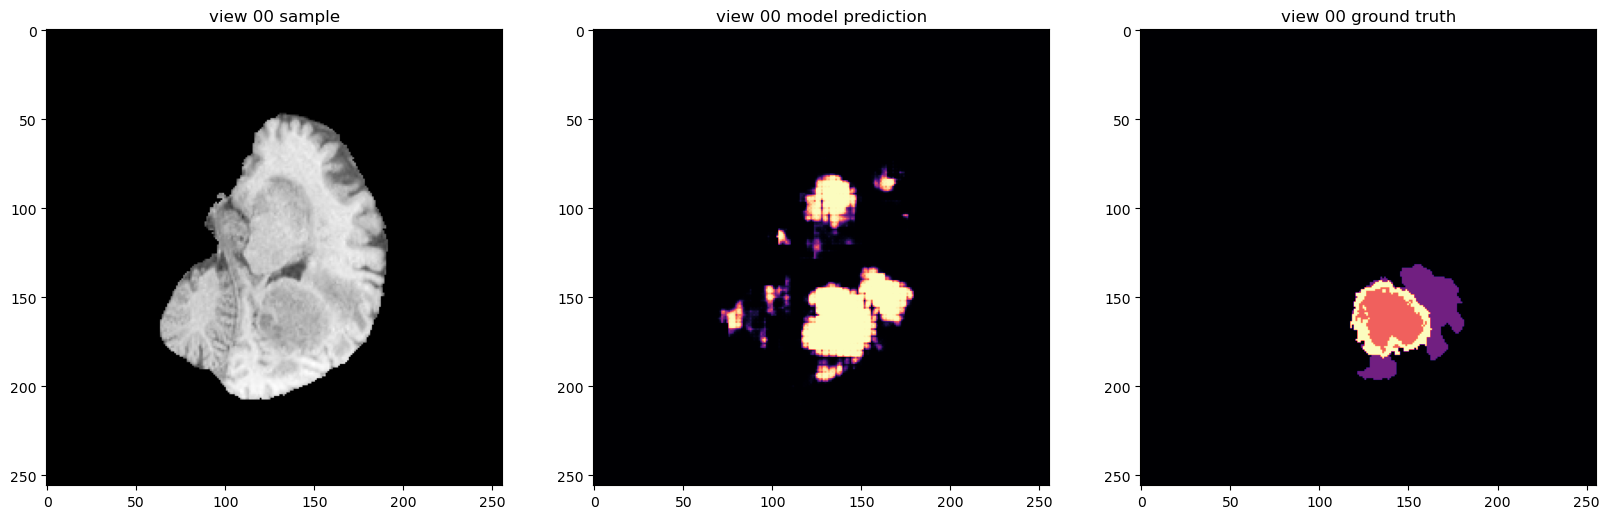

----------
epoch 5/20
epoch 5 average loss: 0.6301
current epoch: 5 train_set mean dice: 0.4249
time consuming of epoch 5 is: 24.8511
inspection of results with random sample from training


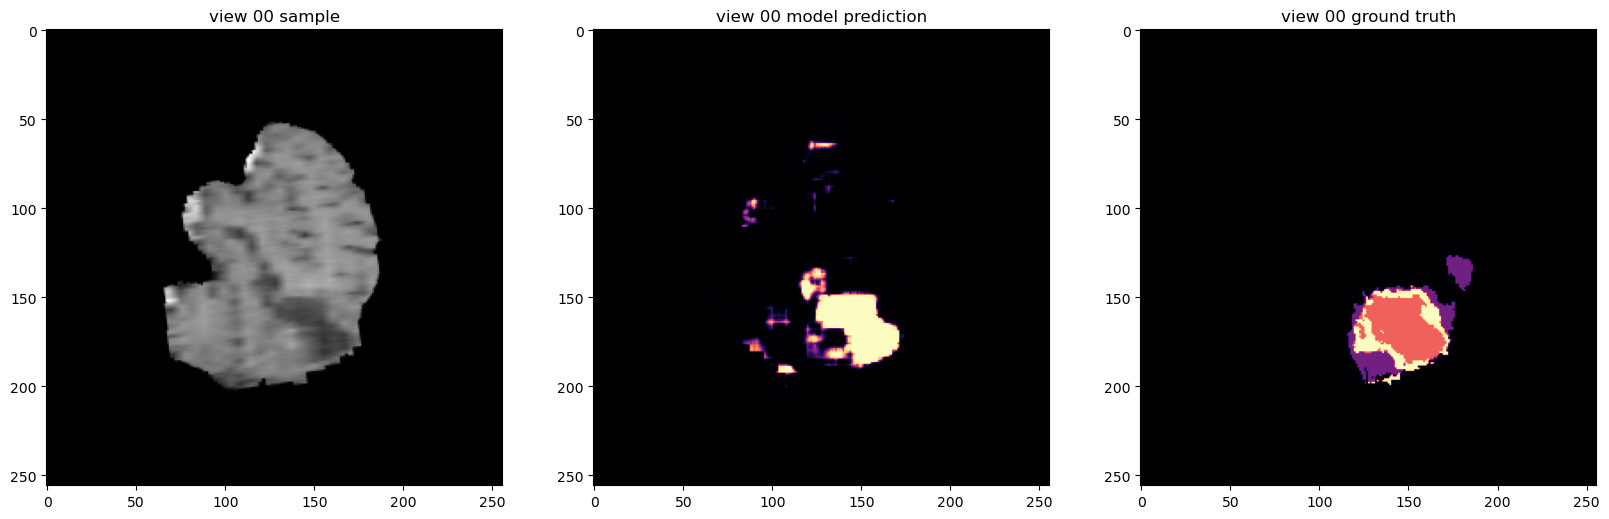

----------
epoch 6/20
epoch 6 average loss: 0.6281
current epoch: 6 train_set mean dice: 0.4292
time consuming of epoch 6 is: 24.4580
inspection of results with random sample from training


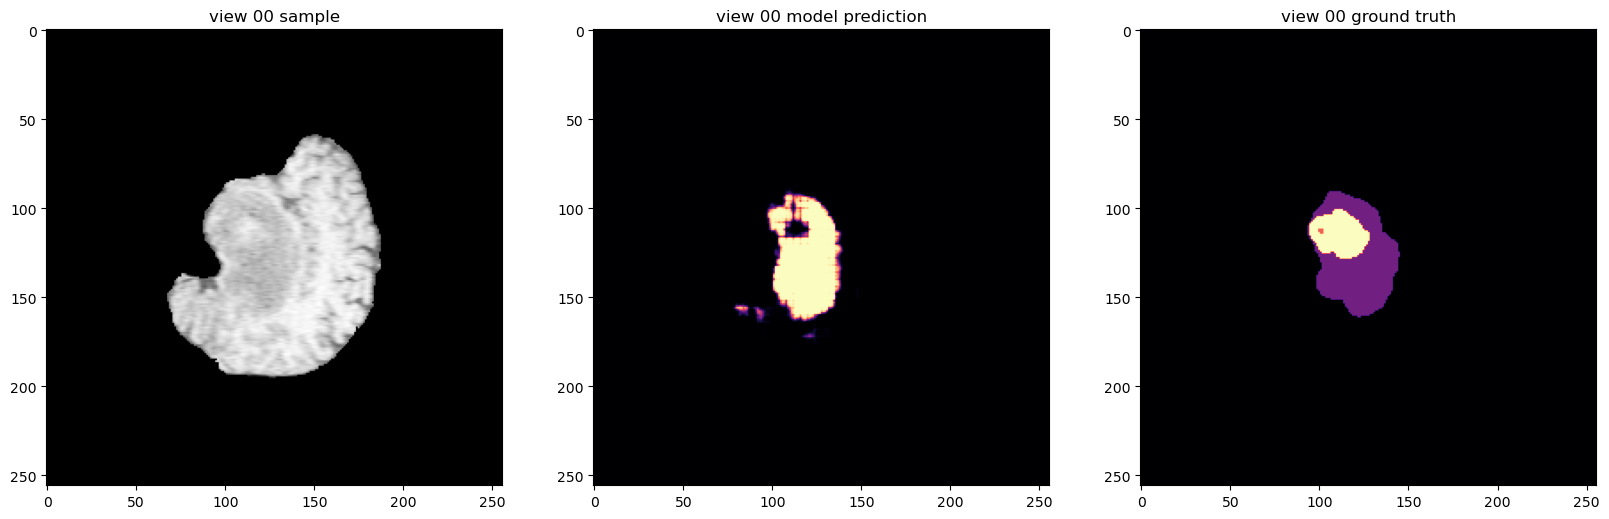

----------
epoch 7/20
epoch 7 average loss: 0.6277
current epoch: 7 train_set mean dice: 0.4281
time consuming of epoch 7 is: 23.6729
inspection of results with random sample from training


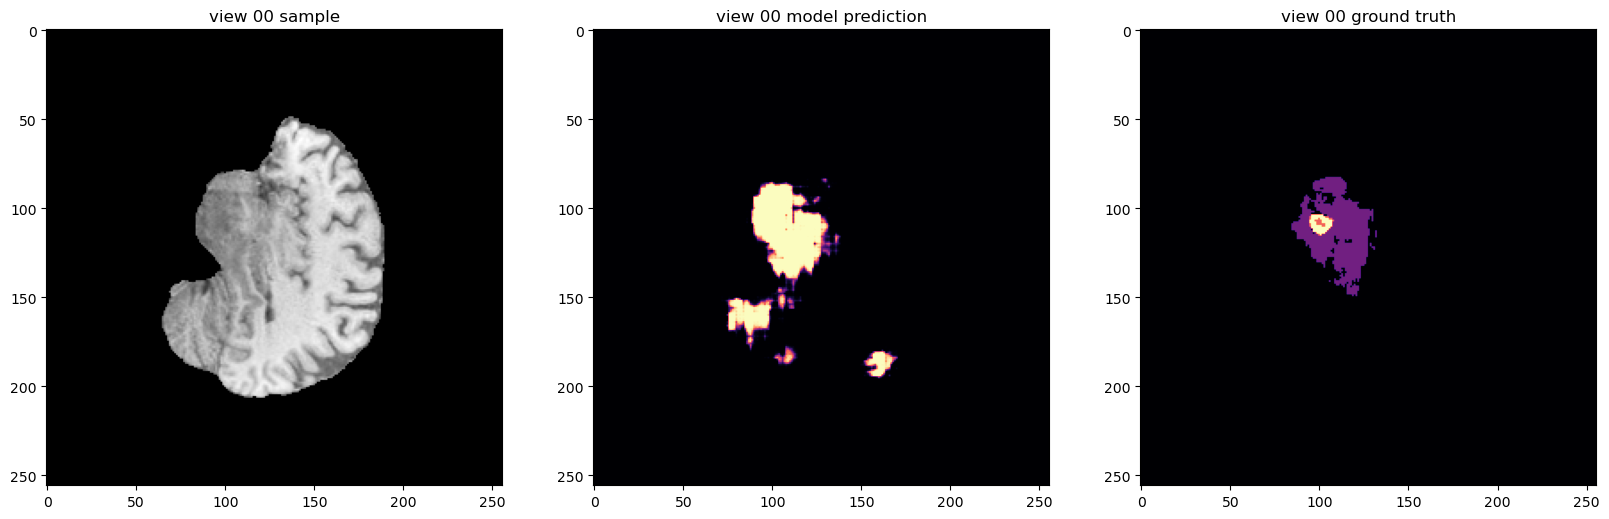

----------
epoch 8/20
epoch 8 average loss: 0.6221
current epoch: 8 train_set mean dice: 0.4328
time consuming of epoch 8 is: 23.4987
inspection of results with random sample from training


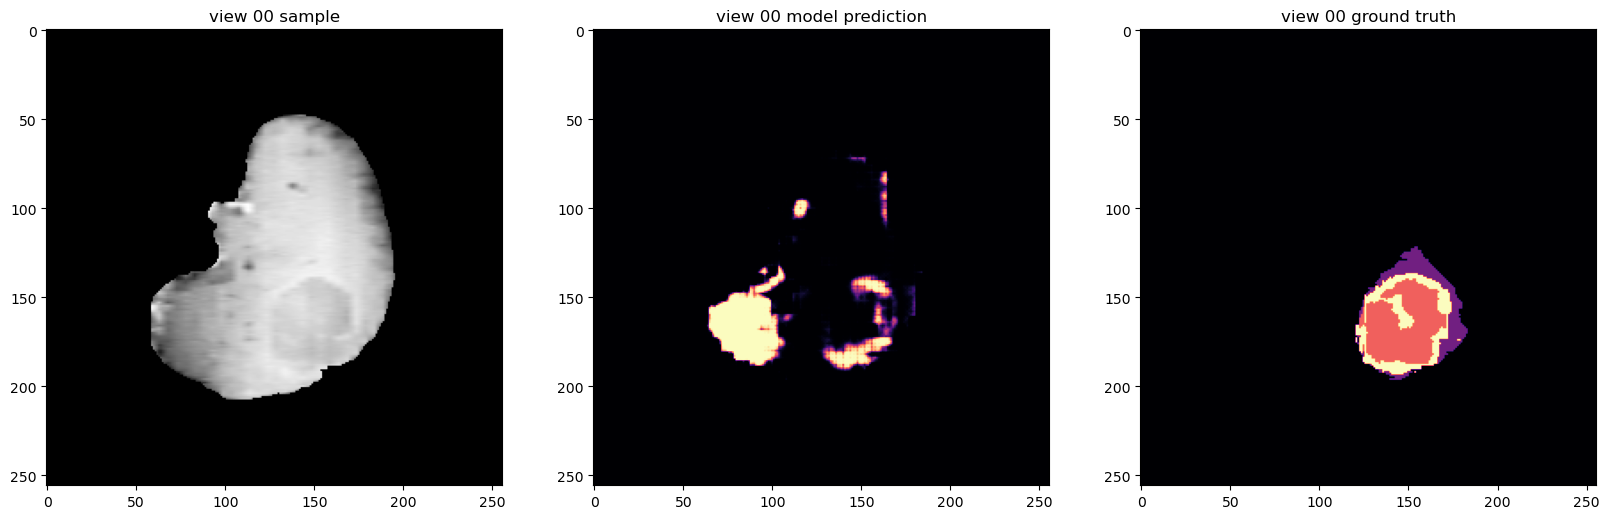

----------
epoch 9/20
epoch 9 average loss: 0.6209
current epoch: 9 train_set mean dice: 0.4314
time consuming of epoch 9 is: 25.0610
inspection of results with random sample from training


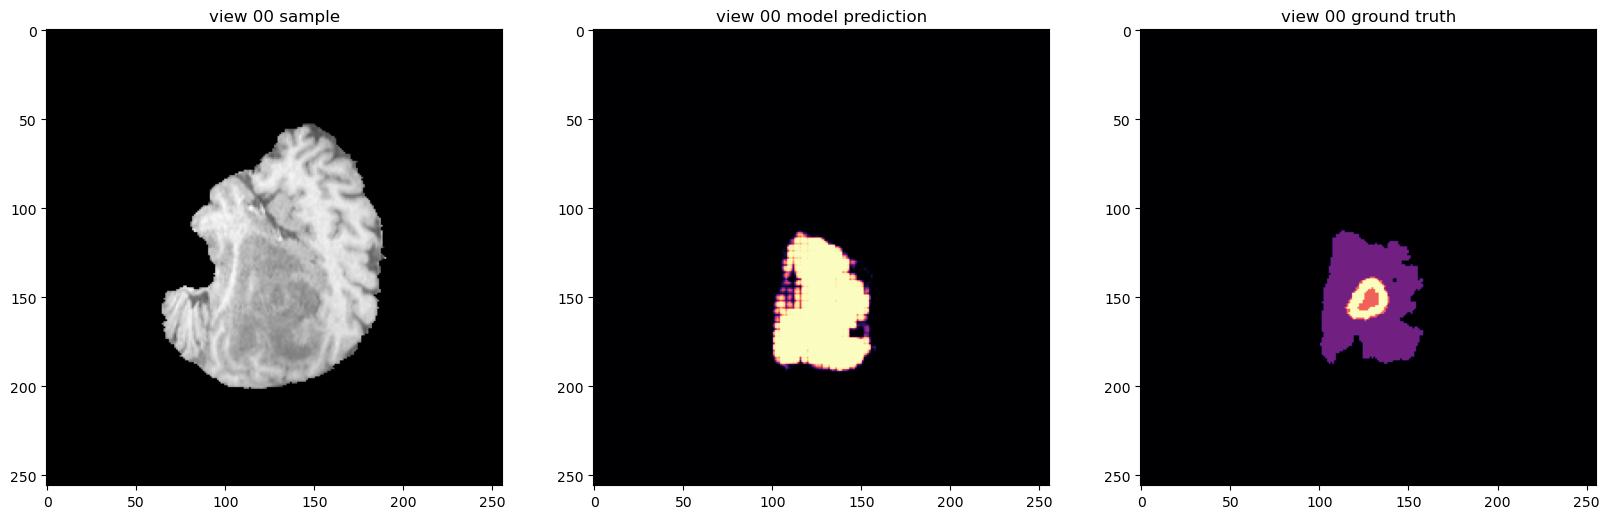

----------
epoch 10/20
epoch 10 average loss: 0.6185
current epoch: 10 train_set mean dice: 0.4341
time consuming of epoch 10 is: 24.4156
inspection of results with random sample from training


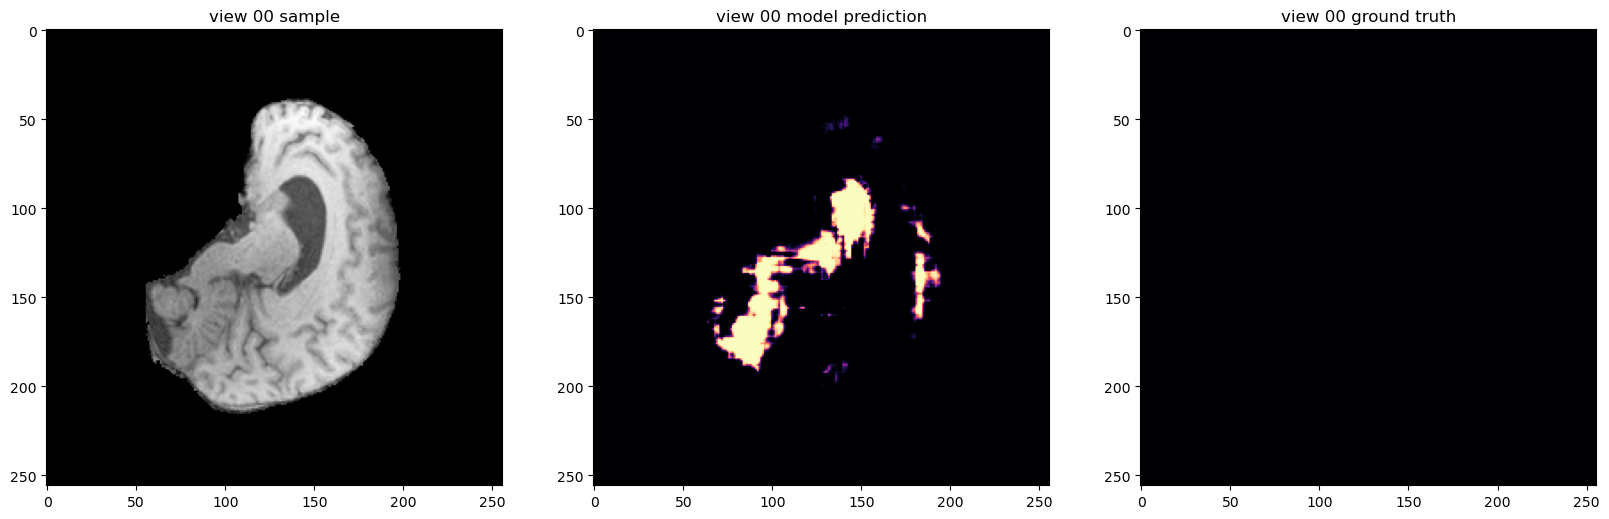

----------
epoch 11/20
epoch 11 average loss: 0.6210
current epoch: 11 train_set mean dice: 0.4335
time consuming of epoch 11 is: 24.1919
inspection of results with random sample from training


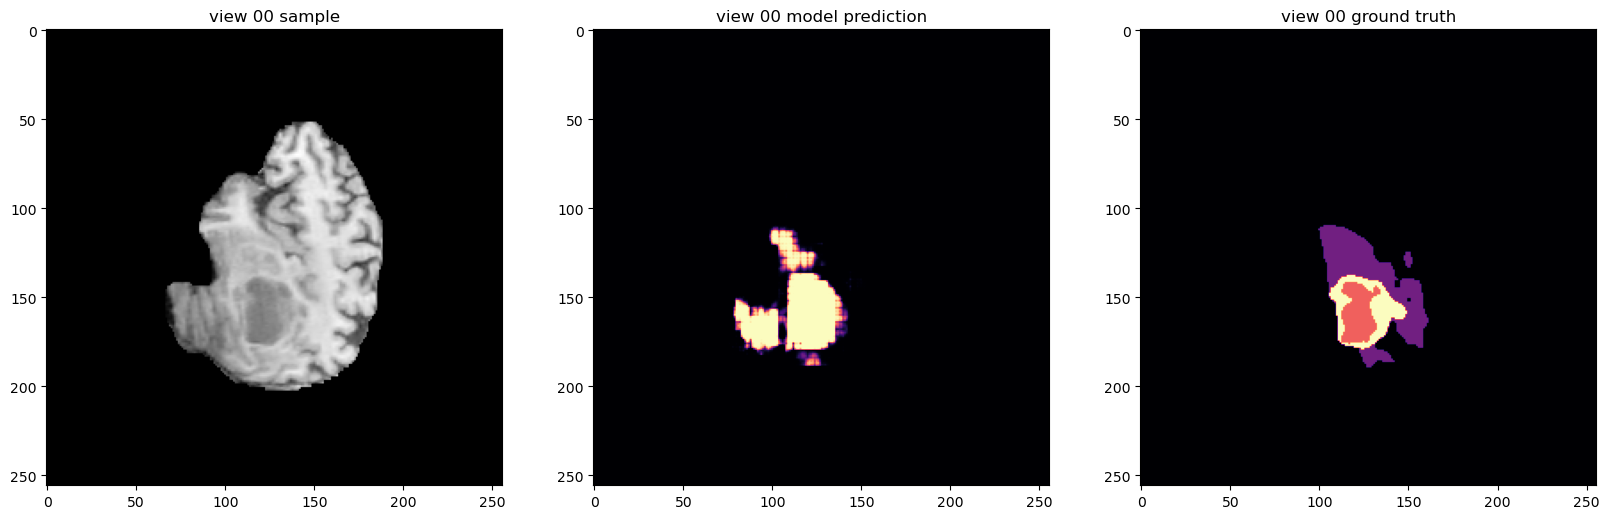

----------
epoch 12/20
epoch 12 average loss: 0.6203
current epoch: 12 train_set mean dice: 0.4359
time consuming of epoch 12 is: 23.3773
inspection of results with random sample from training


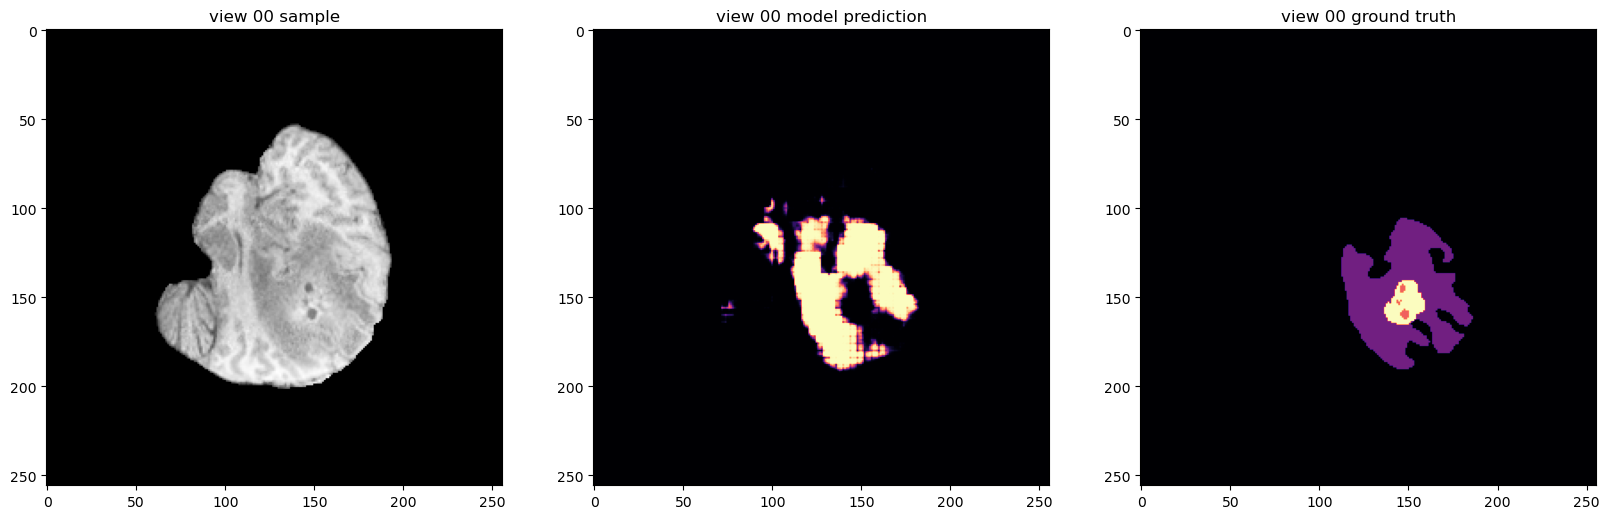

----------
epoch 13/20
epoch 13 average loss: 0.6134
current epoch: 13 train_set mean dice: 0.4386
time consuming of epoch 13 is: 22.9985
inspection of results with random sample from training


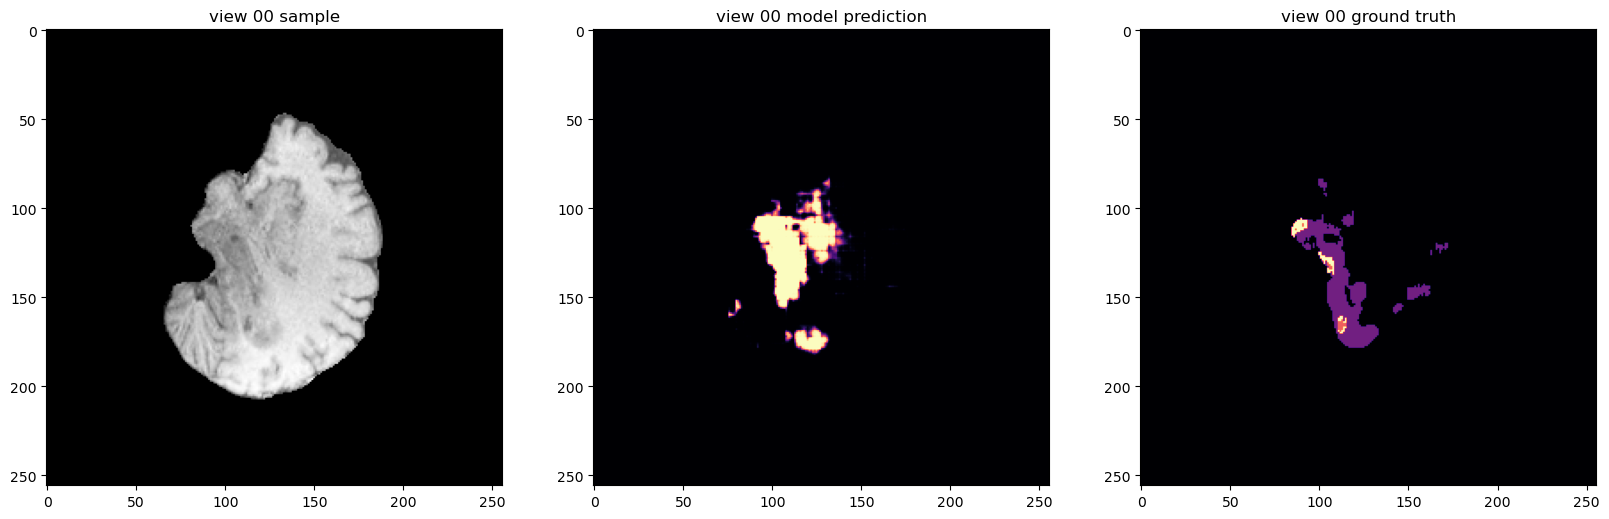

----------
epoch 14/20
epoch 14 average loss: 0.6189
current epoch: 14 train_set mean dice: 0.4385
time consuming of epoch 14 is: 24.5045
inspection of results with random sample from training


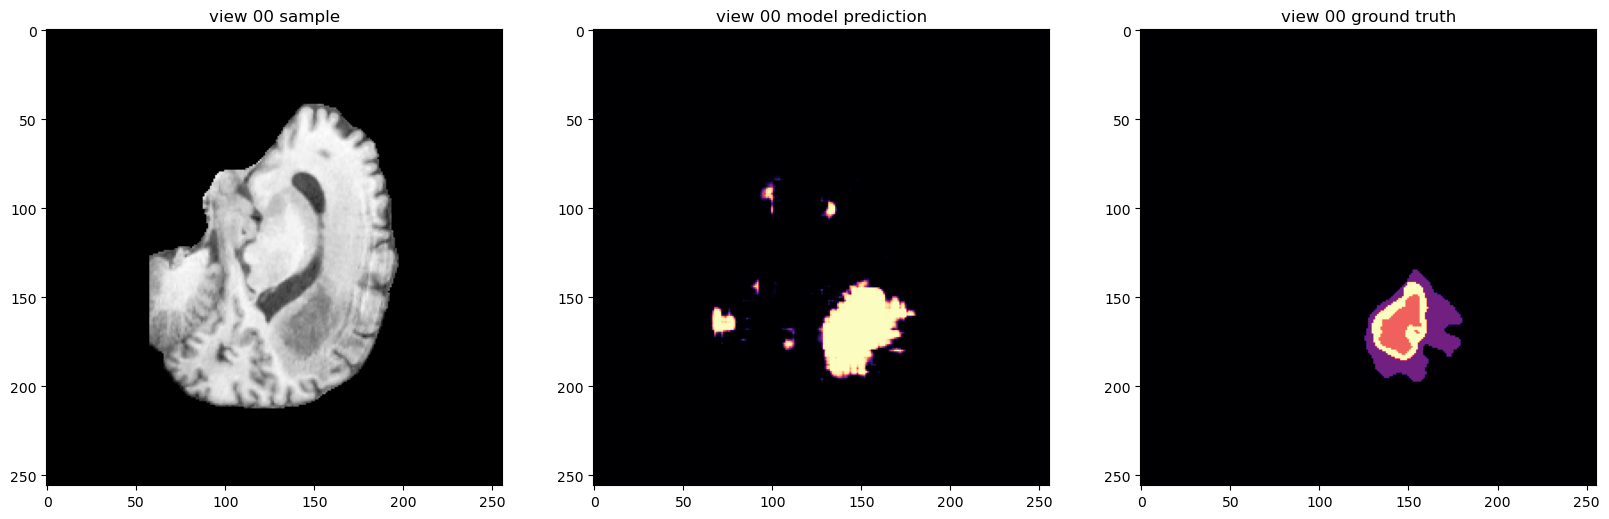

----------
epoch 15/20
epoch 15 average loss: 0.6151
current epoch: 15 train_set mean dice: 0.4378
time consuming of epoch 15 is: 24.3320
inspection of results with random sample from training


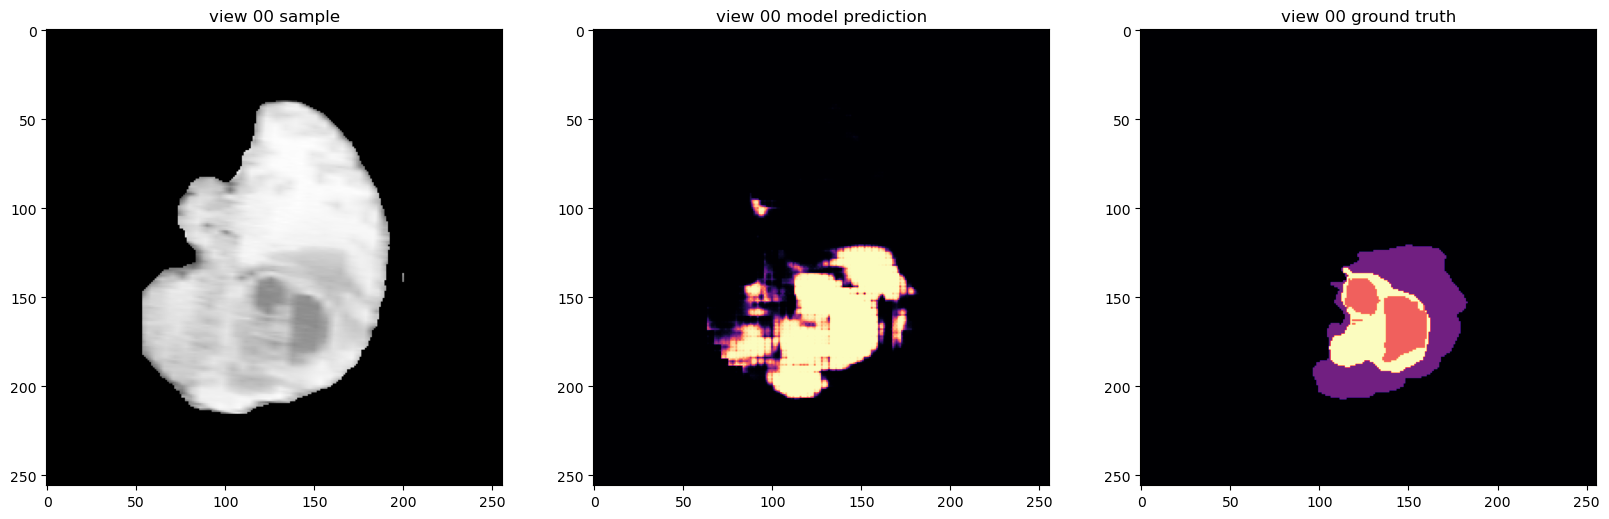

----------
epoch 16/20
epoch 16 average loss: 0.6092
current epoch: 16 train_set mean dice: 0.4418
time consuming of epoch 16 is: 23.5083
inspection of results with random sample from training


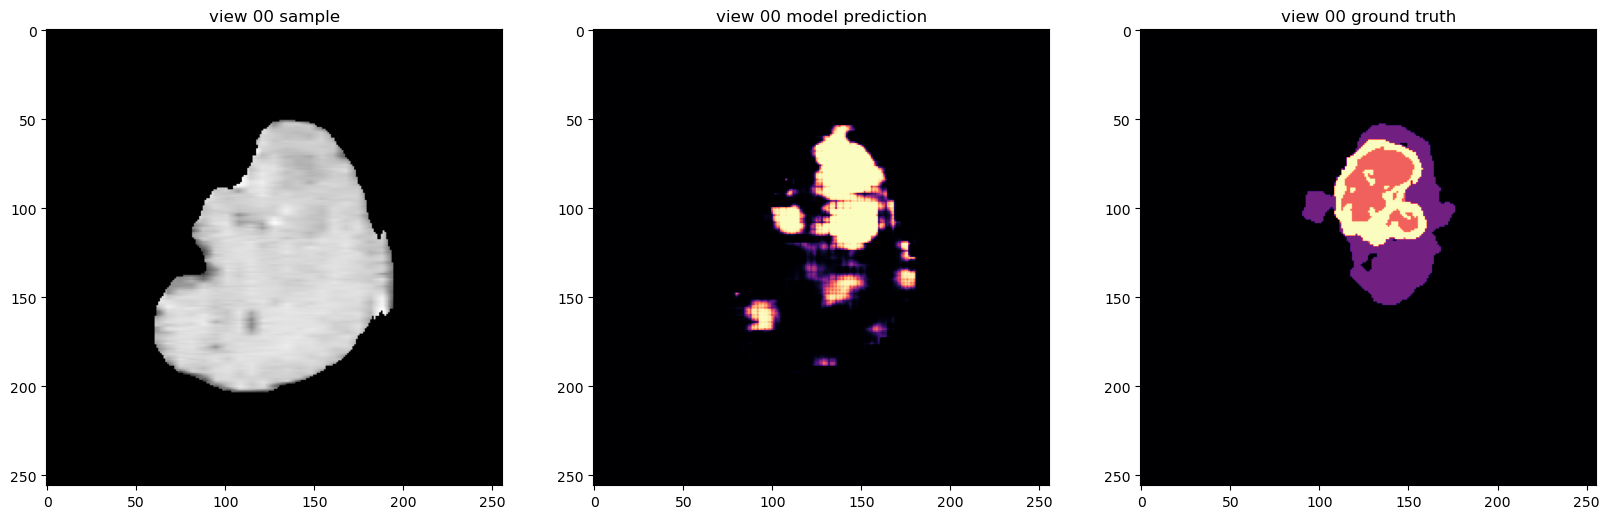

----------
epoch 17/20
epoch 17 average loss: 0.6087
current epoch: 17 train_set mean dice: 0.4427
time consuming of epoch 17 is: 24.4346
inspection of results with random sample from training


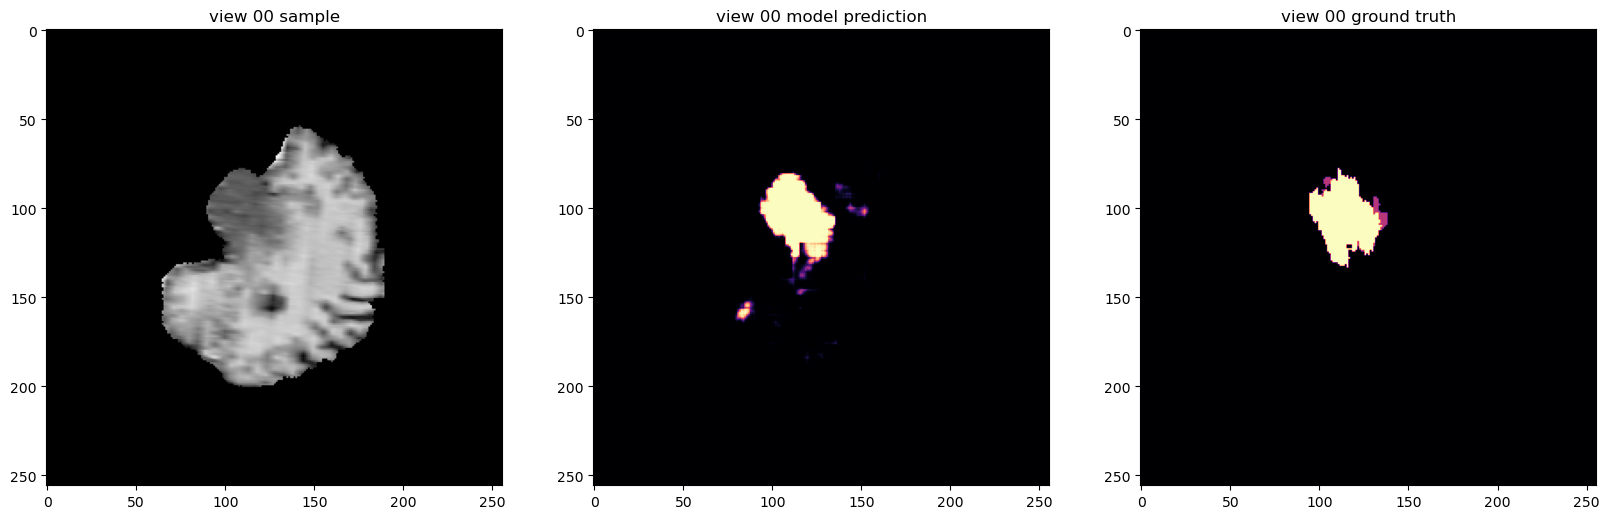

----------
epoch 18/20
epoch 18 average loss: 0.6045
current epoch: 18 train_set mean dice: 0.4458
time consuming of epoch 18 is: 23.2330
inspection of results with random sample from training


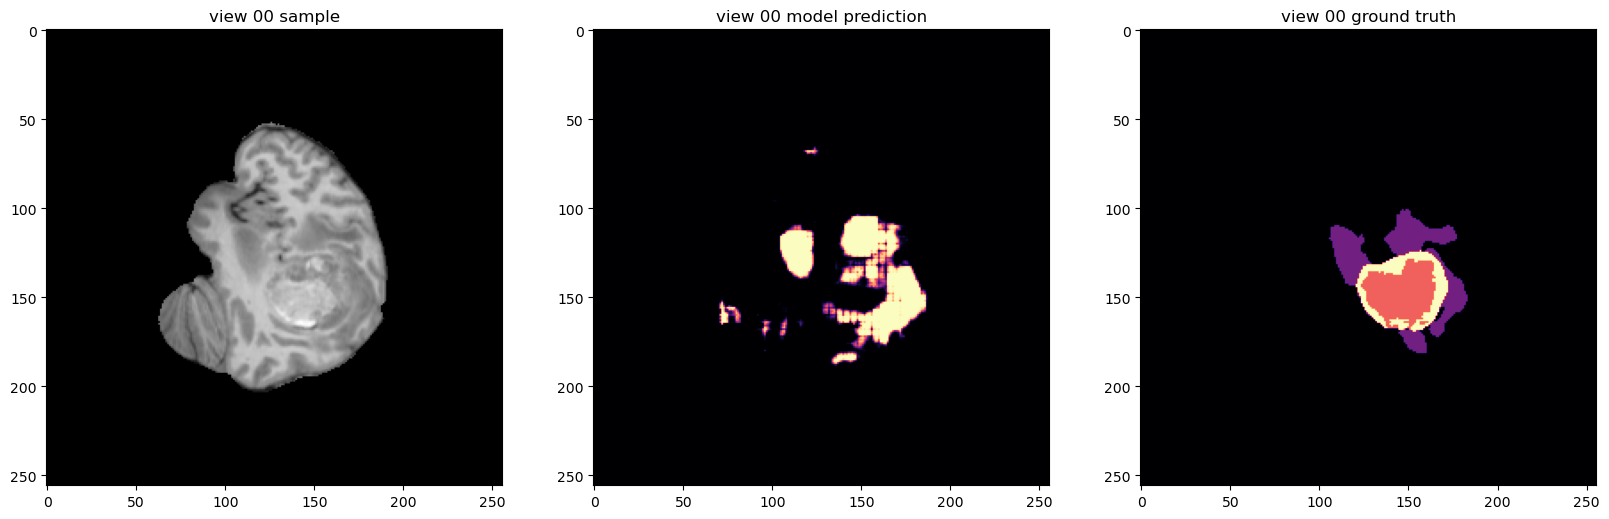

----------
epoch 19/20
epoch 19 average loss: 0.6099
current epoch: 19 train_set mean dice: 0.4438
time consuming of epoch 19 is: 25.1964
inspection of results with random sample from training


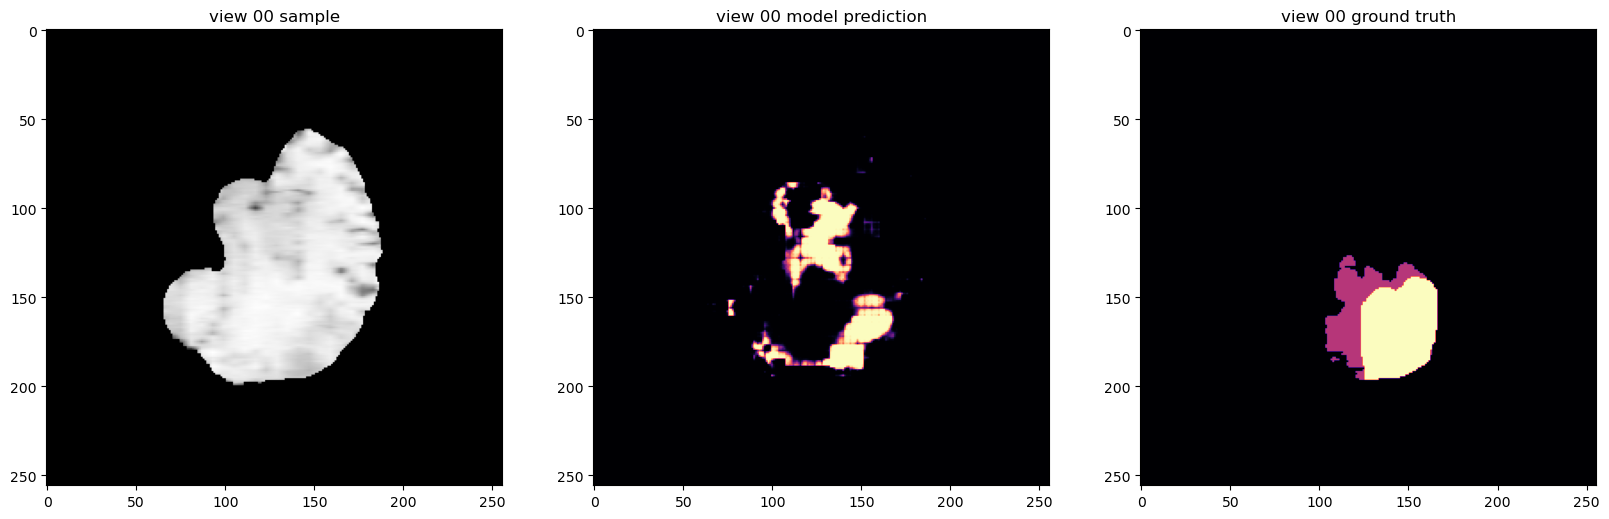

----------
epoch 20/20
epoch 20 average loss: 0.6101
current epoch: 20 train_set mean dice: 0.4434
time consuming of epoch 20 is: 24.7418
inspection of results with random sample from training


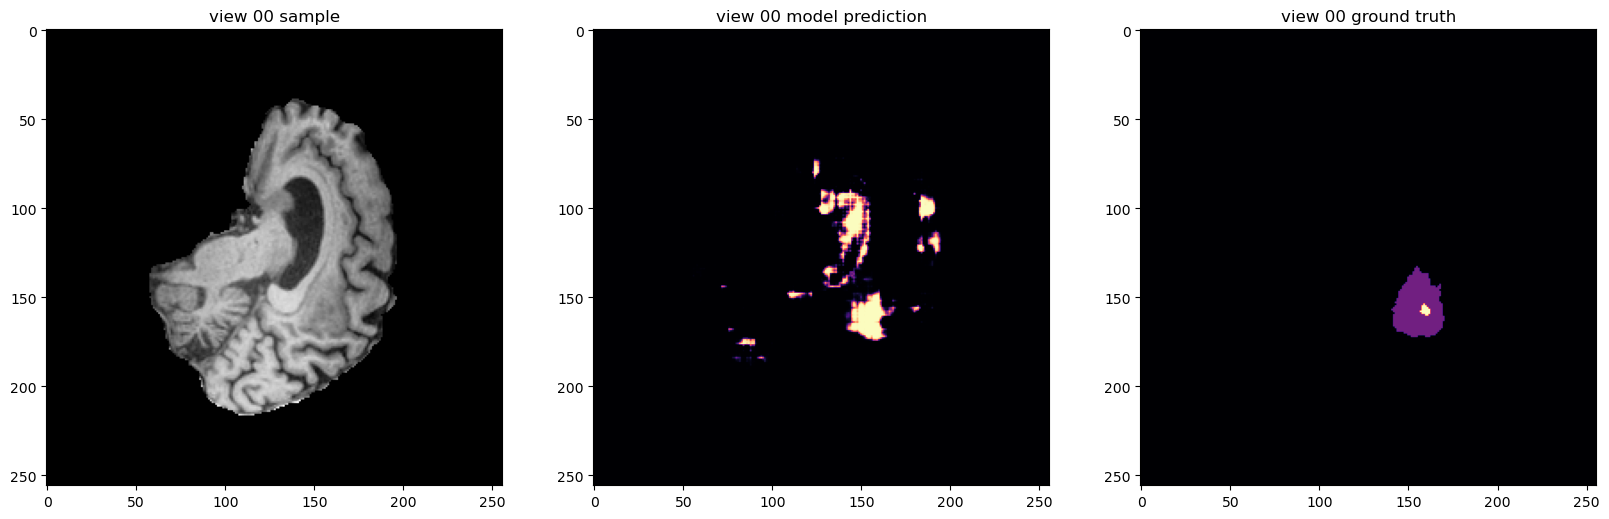

In [37]:
total_start = time.time()

# initialize lists for recording training history
epoch_loss_values = []
epoch_dice_scores = []
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    epoch_loss = 0
    steps = 0
    
    # count batch_index and load batch of images and labels
    for batch_idx, batch_data in enumerate(train_loader):
        step_start = time.time()
        steps += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["mask"].to(device),
        )
        # predict
        outputs = model(inputs)
        # compute loss based on predictions
        loss = loss_function(outputs, labels)
        # compute gradients
        loss.backward()
        # apply weight update based on gradients
        optimizer.step()
        # reset optimizer state for next batch update
        optimizer.zero_grad()

        # increase the loss for the current epoch
        epoch_loss += loss.item()

        # compute Dice score for current predictions
        outputs_ = torch.nn.functional.sigmoid(outputs.detach().clone())
        outputs_[outputs_>=0.5] = 1
        outputs_[outputs_<0.5] = 0
        dice_metric(y_pred=outputs_, y=labels)

    # compute average loss of this epoch and add to history
    epoch_loss /= steps
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    
    # compute average Dice of this epoch and add to history
    metric = dice_metric.aggregate().item()
    epoch_dice_scores.append(metric)
    dice_metric.reset()
    print(f"current epoch: {epoch + 1} train_set mean dice: {metric:.4f}")
    
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
    print("inspection of results with random sample from training")
    
    # eval mode to test on a training sample, without dropout and without learning from gradients
    model.eval()
    with torch.no_grad():
        batch = next(iter(train_loader))
        inputs, labels = batch["image"].to(device), batch["mask"].to(device)
        outputs = model(inputs)
    brain_img = inputs[0].detach().cpu()
    mask_img = labels[0].detach().cpu()
    mask_out = torch.nn.functional.sigmoid(outputs[0].detach().cpu())
    
    # Plot
    plt.figure(figsize=(20,10))
    plt.subplot(1, 3, 1)
    plt.title(f"view 00 sample")
    plt.imshow(brain_img[0], cmap="Greys_r")
    
    plt.subplot(1, 3, 2)
    plt.title(f"view 00 model prediction")
    mask_out = mask_out.permute(1,2,0).sum(axis=-1)
    plt.imshow(mask_out, cmap="magma")
    
    plt.subplot(1, 3, 3)
    plt.title(f"view 00 ground truth")
    mask_img = mask_img.permute(1,2,0).sum(axis=-1)
    plt.imshow(mask_img, cmap="magma")
    plt.show()
    plt.close()
    
    model.train()
    
total_time = time.time() - total_start

## Model History

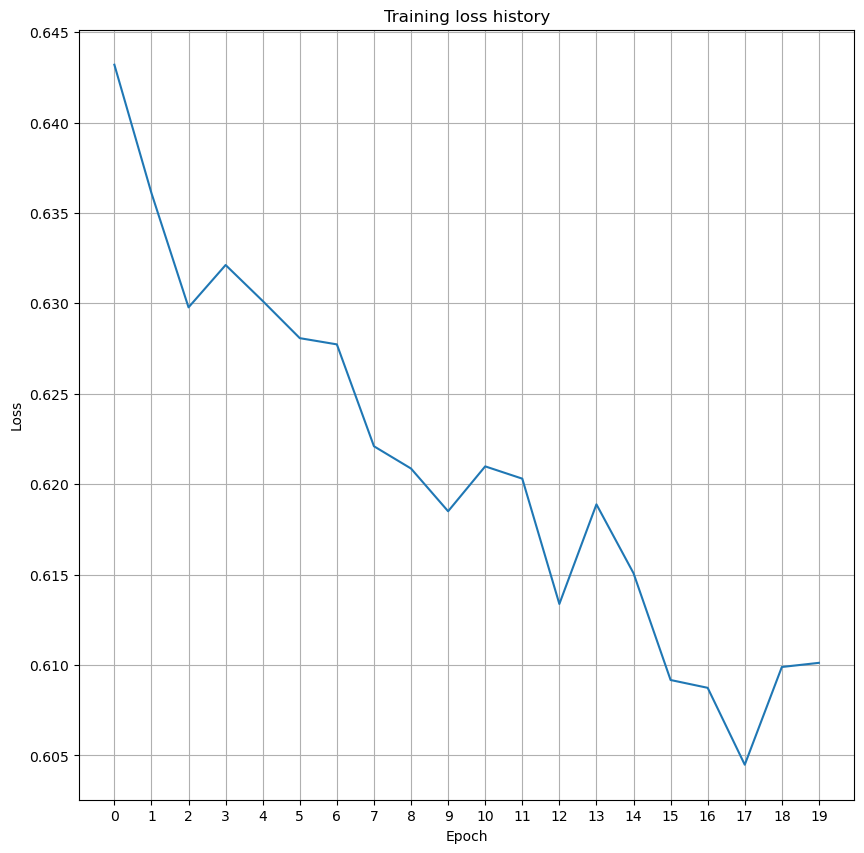

In [38]:
plt.figure(figsize=(10,10))
plt.plot(epoch_loss_values)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([i for i in range(max_epochs)])
plt.title("Training loss history")
plt.grid()
plt.show()
plt.close()